In [1]:
import pandas as pd
import numpy as np
import pyodbc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
conn_str = (
    "DRIVER={ODBC Driver 18 for SQL Server};"
    "SERVER=localhost;"               # default instance
    "DATABASE=DW_Education;"
    "Trusted_Connection=yes;"
    "TrustServerCertificate=yes;"
)

conn = pyodbc.connect(conn_str)
if conn:
    print("Connected successfully")

Connected successfully


In [3]:
query = """
SELECT
    f.IPS,
    f."Taux de réussite" AS Taux_Reussite,
    f."Taux de mentions" AS Taux_Mentions,
    f.Nb_eleves,

    -- Geographic info
    g.Code_postal AS Code_Postal,
    g.Nom_commune AS Ville,
    g.Libelle_region AS Region,

    -- Etablissement info
    e.UAI AS UAI,
    e.Nom_etablissement AS Nom_Etablissement,
    e.Statut_public_prive AS Statut_Etablissement,

    -- Date info
    d.Annee,
    d.Mois,
    d.Jour,

    -- Section info
    s.Code_Section,

    -- Voie info
    v.Code_Voie,

    -- Type Etablissement info
    t.Code_TypeEtab,

    -- Service info
    srv.Code_Service

FROM dbo.factEtablissement2 AS f

-- Join each dimension
LEFT JOIN dbo.dim_geographie AS g
    ON f.Geographie_FK = g.Geographie_PK

LEFT JOIN dbo.dim_etablissment AS e
    ON f.Etablissment_FK = e.Etablissment_PK

LEFT JOIN dbo.dim_Date AS d
    ON f.Date_FK = d.Date_PK

LEFT JOIN dbo.dim_Section AS s
    ON f.Section_FK = s.Section_PK

LEFT JOIN dbo.dim_Voie AS v
    ON f.Voie_FK = v.Voie_PK

LEFT JOIN dbo.dim_TypeEtablissement AS t
    ON f.TypeEtab_FK = t.TypeEtab_PK

LEFT JOIN dbo.dim_Service AS srv
    ON f.Service_FK = srv.Service_PK;

"""

df = pd.read_sql(query, conn)
df.head()

C:\Users\mk\AppData\Local\Temp\ipykernel_33920\2984369686.py:61: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,IPS,Taux_Reussite,Taux_Mentions,Nb_eleves,Code_Postal,Ville,Region,UAI,Nom_Etablissement,Statut_Etablissement,Annee,Mois,Jour,Code_Section,Code_Voie,Code_TypeEtab,Code_Service
0,104.9,91,42.0,16.0,61014,Alençon,Normandie,0610002W,Lycée polyvalent Leclerc - Navarre,Public,1965.0,5.0,1.0,SPO,P,L,GRE
1,104.9,91,42.0,16.0,61014,Alençon,Normandie,0610002W,Lycée polyvalent Leclerc - Navarre,Public,1965.0,5.0,1.0,SPO,T,L,GRE
2,104.9,91,42.0,16.0,61014,Alençon,Normandie,0610002W,Lycée polyvalent Leclerc - Navarre,Public,1965.0,5.0,1.0,SPO,G,L,GRE
3,104.9,91,42.0,16.0,61014,Alençon,Normandie,0610002W,Lycée polyvalent Leclerc - Navarre,Public,1965.0,5.0,1.0,SPO,G,L,GRE
4,104.9,91,42.0,16.0,61014,Alençon,Normandie,0610002W,Lycée polyvalent Leclerc - Navarre,Public,1965.0,5.0,1.0,SPO,P,L,GRE


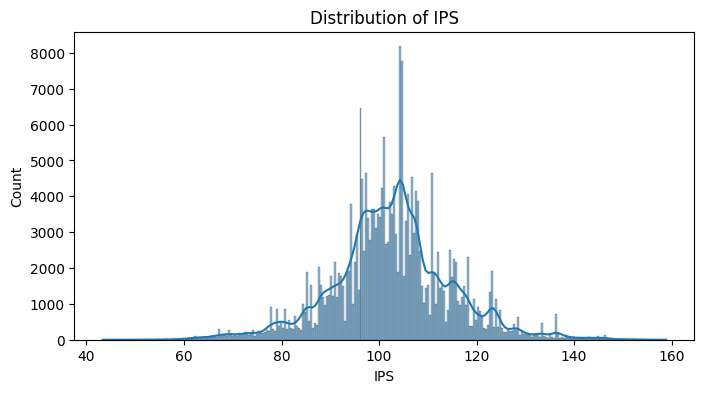

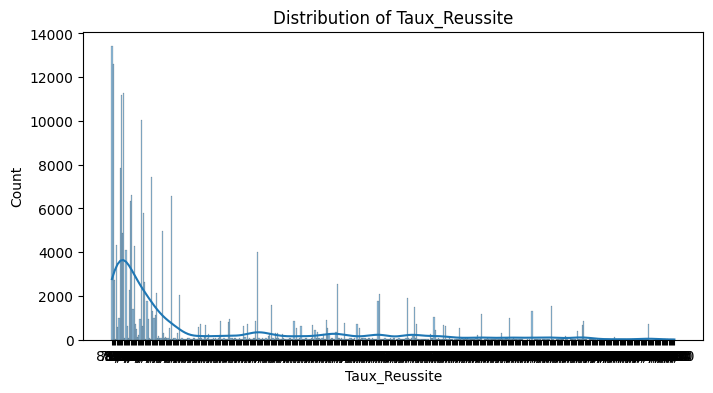

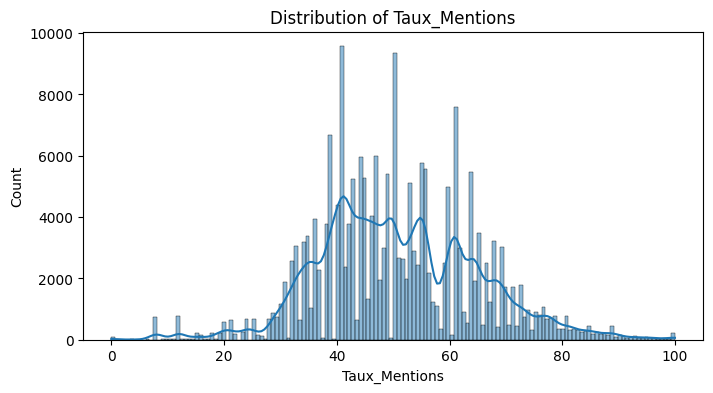

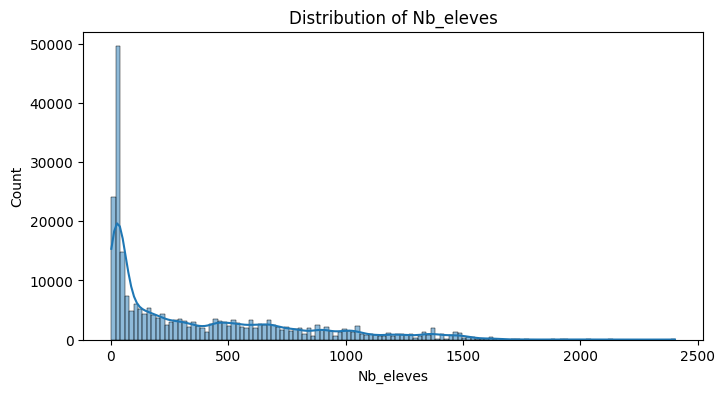

In [4]:
# -----------------------------
# NUMERIC DISTRIBUTIONS
# -----------------------------
numeric_cols = ["IPS", "Taux_Reussite", "Taux_Mentions", "Nb_eleves"]


for col in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

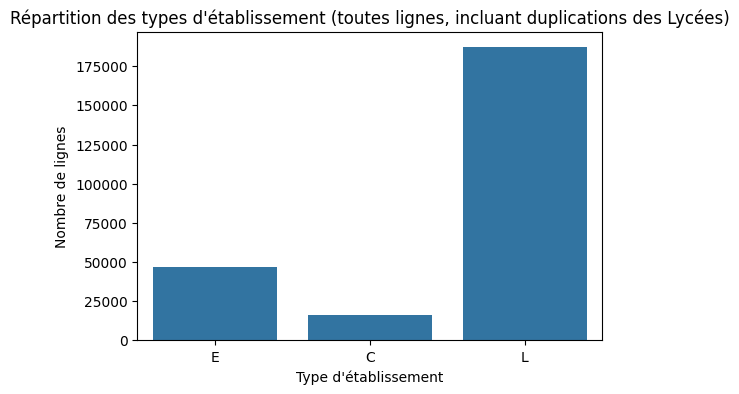

In [5]:
# ===========================================
# 4. Visualisation exploratoire
# ===========================================
# Répartition des types d'établissement (toutes lignes)
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Code_TypeEtab', order=['E','C','L'])
plt.title("Répartition des types d'établissement (toutes lignes, incluant duplications des Lycées)")
plt.xlabel("Type d'établissement")
plt.ylabel("Nombre de lignes")
plt.show()

In [6]:
# -----------------------------
# OUTLIER DETECTION (IQR METHOD)
# -----------------------------
def remove_outliers_iqr(data, cols):
    cleaned = data.copy()
    for col in cols:
        Q1 = cleaned[col].quantile(0.25)
        Q3 = cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        cleaned = cleaned[(cleaned[col] >= lower) & (cleaned[col] <= upper)]
    return cleaned

In [7]:
df['Taux_Reussite'] = pd.to_numeric(df['Taux_Reussite'], errors='coerce')

In [8]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(numeric_cols)

['IPS', 'Taux_Reussite', 'Taux_Mentions', 'Nb_eleves', 'Annee', 'Mois', 'Jour']


In [9]:
numeric_cols = ['IPS', 'Taux_Reussite', 'Taux_Mentions', 'Nb_eleves','Annee']
categorical_cols = ['Region', 'Code_Section', 'Code_Voie', 'Code_Service', 'Code_TypeEtab','Statut_Etablissement']

df["Nb_eleves"]= df["Nb_eleves"].fillna(df["Nb_eleves"].median())
df["Taux_Reussite"]= df["Taux_Reussite"].fillna(df["Taux_Reussite"].median())
df["Taux_Mentions"]= df["Taux_Mentions"].fillna(df["Taux_Mentions"].mean())
df["IPS"]= df["IPS"].fillna(df["IPS"].mean())
df["Annee"]= df["Annee"].fillna(df["Annee"].median())


for col in categorical_cols:
    mode_val = df[col].mode()[0]  # most frequent value
    df[col] = df[col].fillna(mode_val)



In [10]:
df_grouped = df.groupby('UAI').agg({
    'IPS': 'median',                   # numeric
    'Taux_Reussite': 'median',         # numeric
    'Taux_Mentions': 'median',         # numeric
    'Nb_eleves': 'first',                # total students
    'Region': lambda x: x.mode()[0],   # most common region
    'Code_TypeEtab': lambda x: x.mode()[0],  # most common type
    'Code_Section': lambda x: ','.join(sorted(set(x.dropna()))),
    'Code_Service': lambda x: ','.join(sorted(set(x.dropna()))),
    'Code_Voie': lambda x: ','.join(sorted(set(x.dropna()))),
    'Statut_Etablissement': 'first',  # keep the target

}).reset_index()

In [11]:
print("Original size:", df_grouped.shape)
cols_for_outlier_removal = ['IPS','Nb_eleves']
df_grouped = remove_outliers_iqr(df_grouped,cols_for_outlier_removal )
print("After outlier removal:", df_grouped.shape)

Original size: (51361, 11)
After outlier removal: (39547, 11)


In [12]:
from sklearn.preprocessing import MultiLabelBinarizer

# Sections
df_grouped['Section_list'] = df_grouped['Code_Section'].str.split(',')
mlb_sec = MultiLabelBinarizer()
sec_dummies = pd.DataFrame(mlb_sec.fit_transform(df_grouped['Section_list']),
                           columns=[f"sec_{c}" for c in mlb_sec.classes_],
                           index=df_grouped.index)

# Services
df_grouped['Service_list'] = df_grouped['Code_Service'].str.split(',')
mlb_srv = MultiLabelBinarizer()
srv_dummies = pd.DataFrame(mlb_srv.fit_transform(df_grouped['Service_list']),
                           columns=[f"srv_{c}" for c in mlb_srv.classes_],
                           index=df_grouped.index)

# Voies
df_grouped['Voie_list'] = df_grouped['Code_Voie'].str.split(',')
mlb_voie = MultiLabelBinarizer()
voie_dummies = pd.DataFrame(mlb_voie.fit_transform(df_grouped['Voie_list']),
                            columns=[f"voie_{c}" for c in mlb_voie.classes_],
                            index=df_grouped.index)

df_final = pd.concat([df_grouped, sec_dummies, srv_dummies, voie_dummies], axis=1)


In [13]:
df_hashable = df_final.applymap(lambda x: tuple(x) if isinstance(x, list) else x)

num_duplicates = df_hashable.duplicated().sum()
print("Number of full duplicate rows:", num_duplicates)

if num_duplicates > 0:
    print(df_hashable[df_hashable.duplicated(keep=False)])

C:\Users\mk\AppData\Local\Temp\ipykernel_33920\526868079.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_hashable = df_final.applymap(lambda x: tuple(x) if isinstance(x, list) else x)


Number of full duplicate rows: 0


In [14]:
# Check if there are still multiple rows per UAI
duplicates_uai = df_final['UAI'].duplicated().sum()
print("Number of duplicated UAIs:", duplicates_uai)

# Optionally see which UAIs are duplicated
if duplicates_uai > 0:
    print(df_final[df_final['UAI'].duplicated(keep=False)].sort_values('UAI'))

Number of duplicated UAIs: 0


In [15]:
print("Dataset shape:", df_final.shape)
print("Columns:", df_final.columns.tolist())

Dataset shape: (39547, 30)
Columns: ['UAI', 'IPS', 'Taux_Reussite', 'Taux_Mentions', 'Nb_eleves', 'Region', 'Code_TypeEtab', 'Code_Section', 'Code_Service', 'Code_Voie', 'Statut_Etablissement', 'Section_list', 'Service_list', 'Voie_list', 'sec_ART', 'sec_CIN', 'sec_EUR', 'sec_INT', 'sec_SPO', 'sec_THE', 'srv_APP', 'srv_GRE', 'srv_HEB', 'srv_PBC', 'srv_RES', 'srv_SEG', 'srv_ULI', 'voie_G', 'voie_P', 'voie_T']


In [16]:
from sklearn.preprocessing import LabelEncoder

# Define features (X) and target (y)
# Exclude 'UAI', the original list columns, and the target 'Code_TypeEtab'
X = df_final.drop(columns=['UAI', 'Code_Section', 'Code_Service', 'Code_Voie', 'Section_list', 'Service_list', 'Voie_list', 'Code_TypeEtab'])
y = df_final['Code_TypeEtab']

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create a preprocessor for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Pipeline SVM with specified parameters, enabling probability estimation for ROC curve
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(C=10, gamma='scale', kernel='linear', class_weight='balanced', probability=True))  # Apply desired parameters directly
])

In [17]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [18]:
print(df_final['Code_TypeEtab'].value_counts(dropna=False))


Code_TypeEtab
E    36354
C     2040
L     1153
Name: count, dtype: int64


In [19]:
# Fit the pipeline directly with the specified parameters
pipeline.fit(X_train, y_train)
print("Model trained with fixed parameters.")

Model trained with fixed parameters.



Classification Report :

              precision    recall  f1-score   support

           C       0.96      0.97      0.96       408
           E       1.00      1.00      1.00      7271
           L       0.94      0.95      0.95       231

    accuracy                           1.00      7910
   macro avg       0.97      0.97      0.97      7910
weighted avg       1.00      1.00      1.00      7910



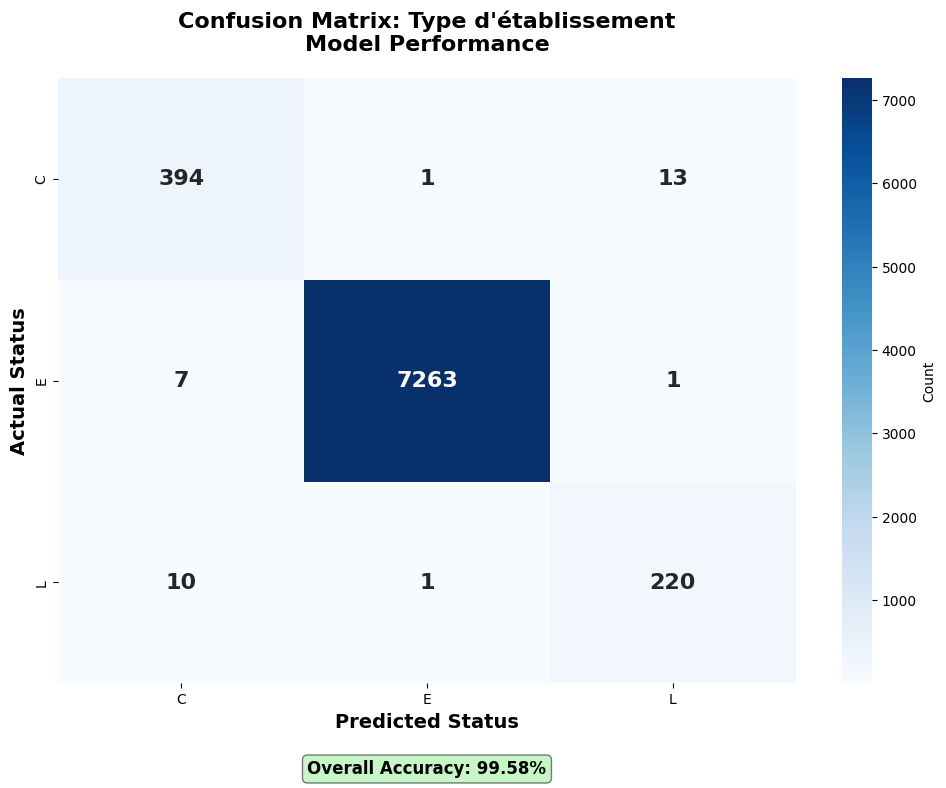


CONFUSION MATRIX BREAKDOWN
True C (True C):   394
False Positive (C predicted as E or L): 14
False Negative (E or L as C): 17
--------------------------------------------------
True E (True E):   7,263
False Positive (E predicted as C or L): 8
False Negative (C or L as E): 2
--------------------------------------------------
True L (True L):   220
False Positive (L predicted as C or E): 11
False Negative (C or E as L): 14
Overall Accuracy: 99.58%
Total Predictions: 7,910


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ===========================================
# 8. Évaluation du modèle
# ===========================================
y_pred = pipeline.predict(X_test)

print("\nClassification Report :\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# ========================================
# PLOT CONFUSION MATRIX
# ========================================
plt.figure(figsize=(10, 8))

# Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 16, 'weight': 'bold'})

plt.xlabel('Predicted Status', fontsize=14, fontweight='bold')
plt.ylabel('Actual Status', fontsize=14, fontweight='bold')
plt.title("Confusion Matrix: Type d'établissement\nModel Performance",
          fontsize=16, fontweight='bold', pad=20)

# Add accuracy text
accuracy = cm.diagonal().sum() / cm.sum()
plt.text(0.5, -0.15, f'Overall Accuracy: {accuracy:.2%}',
         transform=plt.gca().transAxes,
         fontsize=12, ha='center', fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.tight_layout()
plt.show()

# ========================================
# PRINT DETAILED METRICS
# ========================================
print("\n" + "="*50)
print("CONFUSION MATRIX BREAKDOWN")
print("="*50)

# Dynamically get class names
class_names = le.classes_

# Assuming a 3x3 confusion matrix for C, E, L in order
# Note: The indices might need adjustment if class order changes or if it's not a 3x3 matrix
if len(class_names) == 3:
    print(f"True {class_names[0]} (True {class_names[0]}):   {cm[0,0]:,}")
    print(f"False Positive ({class_names[0]} predicted as {class_names[1]} or {class_names[2]}): {cm[0,1] + cm[0,2]:,}")
    print(f"False Negative ({class_names[1]} or {class_names[2]} as {class_names[0]}): {cm[1,0] + cm[2,0]:,}")
    print("-"*50)
    print(f"True {class_names[1]} (True {class_names[1]}):   {cm[1,1]:,}")
    print(f"False Positive ({class_names[1]} predicted as {class_names[0]} or {class_names[2]}): {cm[1,0] + cm[1,2]:,}")
    print(f"False Negative ({class_names[0]} or {class_names[2]} as {class_names[1]}): {cm[0,1] + cm[2,1]:,}")
    print("-"*50)
    print(f"True {class_names[2]} (True {class_names[2]}):   {cm[2,2]:,}")
    print(f"False Positive ({class_names[2]} predicted as {class_names[0]} or {class_names[1]}): {cm[2,0] + cm[2,1]:,}")
    print(f"False Negative ({class_names[0]} or {class_names[1]} as {class_names[2]}): {cm[0,2] + cm[1,2]:,}")
else:
    print("Detailed breakdown is designed for 3 classes (C, E, L).")
    print("True Positives:", cm.diagonal())
    print("False Positives:\n", cm.sum(axis=0) - cm.diagonal())
    print("False Negatives:\n", cm.sum(axis=1) - cm.diagonal())

print("="*50)
print(f"Overall Accuracy: {accuracy:.2%}")
print(f"Total Predictions: {cm.sum():,}")
print("="*50)

In [21]:
import pandas as pd

# Create a DataFrame from the confusion matrix for Power BI
confusion_matrix_df = pd.DataFrame(
    cm,
    index=[f'True_{cls}' for cls in le.classes_],
    columns=[f'Predicted_{cls}' for cls in le.classes_]
)

print("Confusion Matrix DataFrame for Power BI:")
display(confusion_matrix_df)

Confusion Matrix DataFrame for Power BI:


,Predicted_C,Predicted_E,Predicted_L
True_C,394,1,13
True_E,7,7263,1
True_L,10,1,220


In [22]:
# Score sur l'ensemble d'entraînement
y_train_pred = pipeline.predict(X_train)
from sklearn.metrics import accuracy_score
print("Train accuracy:", accuracy_score(y_train, y_train_pred))


Train accuracy: 0.997439706672567


In [23]:
y_test_pred = pipeline.predict(X_test)

print("\n=== Classification Report (TEST) ===\n")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))


=== Classification Report (TEST) ===

              precision    recall  f1-score   support

           C       0.96      0.97      0.96       408
           E       1.00      1.00      1.00      7271
           L       0.94      0.95      0.95       231

    accuracy                           1.00      7910
   macro avg       0.97      0.97      0.97      7910
weighted avg       1.00      1.00      1.00      7910



In [24]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

# Scores TRAIN
prec_train, rec_train, f1_train, _ = precision_recall_fscore_support(
    y_train, y_train_pred, labels=[0,1,2]   # selon tes labels encodés
)

# Scores TEST
prec_test, rec_test, f1_test, _ = precision_recall_fscore_support(
    y_test, y_test_pred, labels=[0,1,2]
)

# Tableau comparatif
df_compare = pd.DataFrame({
    "Classe": le.classes_,
    "F1_Train": f1_train,
    "F1_Test": f1_test,
    "Delta": f1_train - f1_test
})

print(df_compare)


  Classe  F1_Train   F1_Test     Delta
0      C  0.978228  0.962149  0.016079
1      E  0.999450  0.999312  0.000138
2      L  0.968022  0.946237  0.021785


In [26]:
import pickle

# Save model AND preprocessors
model_artifacts = {
    'model': pipeline,   # trained Pipeline (preprocessor + SVC)
    'mlb_sec': mlb_sec,  # MultiLabelBinarizer for sections
    'mlb_srv': mlb_srv,  # MultiLabelBinarizer for services
    'mlb_voie': mlb_voie # MultiLabelBinarizer for voies
}

with open(r'C:/Users/mk/Downloads/ecole_college_lycee_complete_model_1.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f)

print("✓ Saved to C:/Users/mk/Downloads/ecole_college_lycee_complete_model_1.pkl")

✓ Saved to C:/Users/mk/Downloads/ecole_college_lycee_complete_model_1.pkl


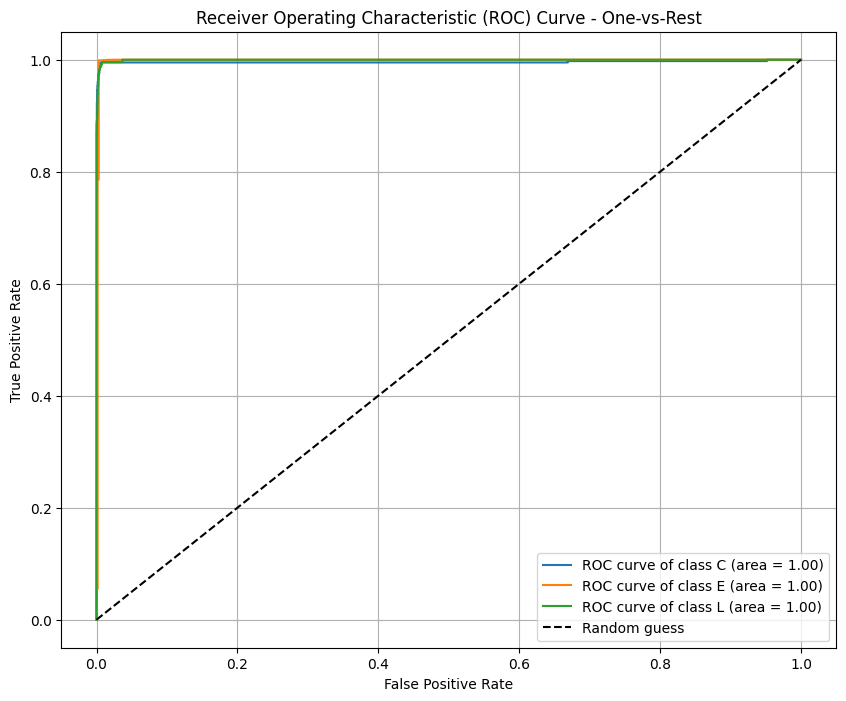

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize


# Get predicted probabilities for each class
y_score = pipeline.predict_proba(X_test)

# Binarize the true labels for ROC curve calculation (one-vs-rest)
y_test_binarized = label_binarize(y_test, classes=range(len(le.classes_)))

plt.figure(figsize=(10, 8))
for i, class_name in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve of class {class_name} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - One-vs-Rest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

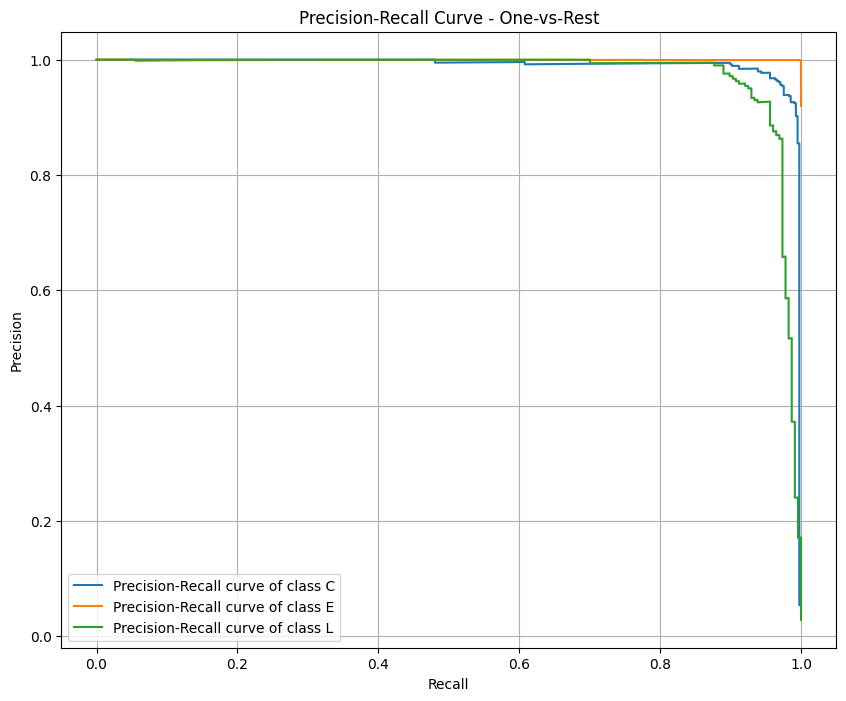

In [39]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.preprocessing import label_binarize

# Get predicted probabilities for each class
y_score = pipeline.predict_proba(X_test)

# Binarize the true labels for Precision-Recall curve calculation (one-vs-rest)
y_test_binarized = label_binarize(y_test, classes=range(len(le.classes_)))

plt.figure(figsize=(10, 8))
for i, class_name in enumerate(le.classes_):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
    plt.plot(recall, precision, label=f'Precision-Recall curve of class {class_name}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - One-vs-Rest')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.preprocessing import label_binarize

# For multi-class classification
y_binarized = label_binarize(y_test, classes=[0, 1])
y_scores = model.predict_proba(X_test)

# Generate ROC for each class
roc_data = []
for i, class_label in enumerate([0, 1]):
    fpr, tpr, _ = roc_curve(y_binarized[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    
    for fp, tp in zip(fpr, tpr):
        roc_data.append({
            'FPR': fp,
            'TPR': tp,
            'Class': f'Class {class_label} (AUC={roc_auc:.4f})'
        })

roc_multi_df = pd.DataFrame(roc_data)
roc_multi_df.to_csv(r'C:/Users/mk/Downloads/roc_curve_ecole_college_lycee.csv', index=False)